In [15]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import torchvision.utils as vutils
import PIL.Image as Image
# Model structure
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 2),
            nn.Tanh()
        )
    def forward(self, inputs):
        codes = self.encoder(inputs)
        return codes
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    def forward(self, inputs):
        outputs = self.decoder(inputs)
        return outputs
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = Encoder()
        # Decoder
        self.decoder = Decoder()
    def forward(self, inputs):
            codes = self.encoder(inputs)
            decoded = self.decoder(codes)
            return codes, decoded

In [16]:
epochs = 20
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
train_loader = DataLoader(datasets.MNIST('D:\Data\mnist', train=True, download=False, transform=transforms.ToTensor()), 
                          batch_size=batch_size, 
                          shuffle=True)
model_ae = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)

In [19]:
from torchsummary import summary
# model = CNN().to('cuda')
summary(model_ae, (1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              Tanh-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              Tanh-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 64]           8,256
              Tanh-6                [-1, 1, 64]               0
            Linear-7                 [-1, 1, 2]             130
              Tanh-8                 [-1, 1, 2]               0
           Encoder-9                 [-1, 1, 2]               0
           Linear-10                [-1, 1, 64]             192
             Tanh-11                [-1, 1, 64]               0
           Linear-12               [-1, 1, 128]           8,320
             Tanh-13               [-1, 1, 128]               0
           Linear-14               [-1,

In [20]:
# Train
log_loss=[]
for epoch in range(epochs):
    total_loss = 0
    for data, _ in train_loader:
        inputs = data.view(-1, 784).to(device) 
        model_ae.zero_grad()
        # Forward
        codes, decoded = model_ae(inputs)
        loss = loss_function(decoded, inputs)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        log_loss.append(loss)
    total_loss /= len(train_loader.dataset)
    scheduler.step()
    
    if epoch % 5 ==0:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

[1/20] Loss: 0.001016662921756506
[6/20] Loss: 0.0005975638632662594
[11/20] Loss: 0.0005606348277069628
[16/20] Loss: 0.000548478274140507
[20/20] Loss: 0.0005417958600446582


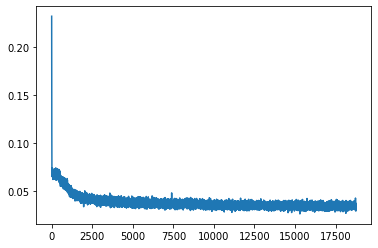

In [21]:
plt.plot(log_loss)
torch.save(model_ae, 'mode_AutoEncoder_MNIST.pth')

Original Images


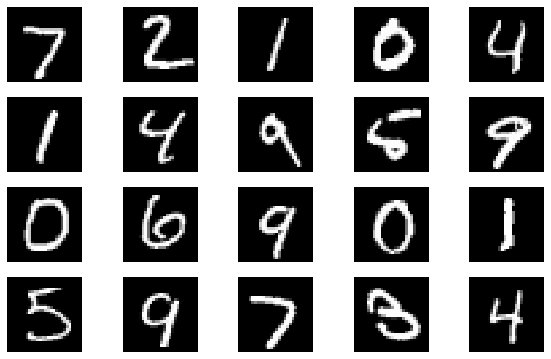

Restructured Image by AE


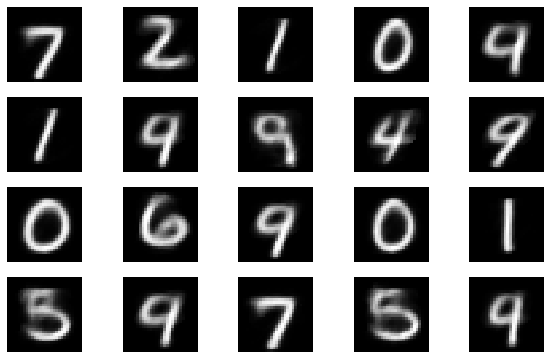

Original Images


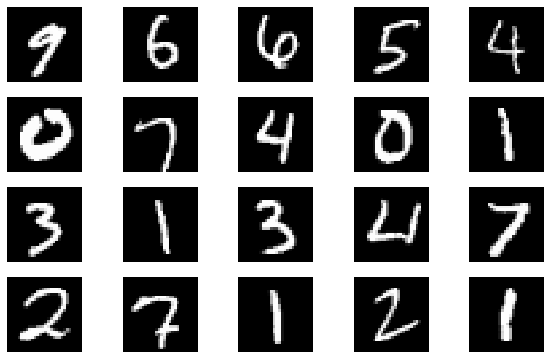

Restructured Image by AE


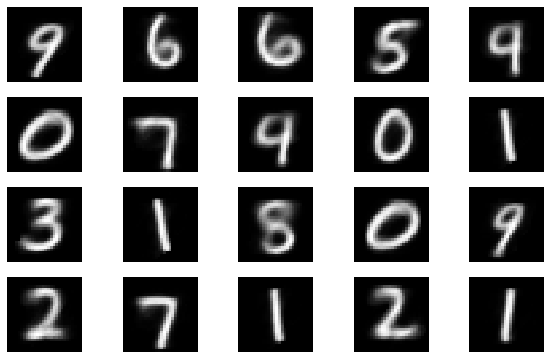

In [23]:
# Settings
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# Show images
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28))
        plt.axis('off')
# Load model
model_ae = torch.load('mode_AutoEncoder_MNIST.pth')
model_ae.eval()
# DataLoader
test_loader = torch.utils.data.DataLoader(datasets.MNIST('D:\Data\mnist', train=False, download=False, transform= transforms.ToTensor()),
                                          batch_size=20)
# Test
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        inputs = data.view(-1, 28*28)
        print('Original Images')
        show_images(inputs)
        plt.show()
# Forward
        codes, outputs = model_ae(inputs.to(device))
        outputs = outputs.detach().cpu()
        print('Restructured Image by AE')
        show_images(outputs)
        plt.show()
        if i>0:
            break

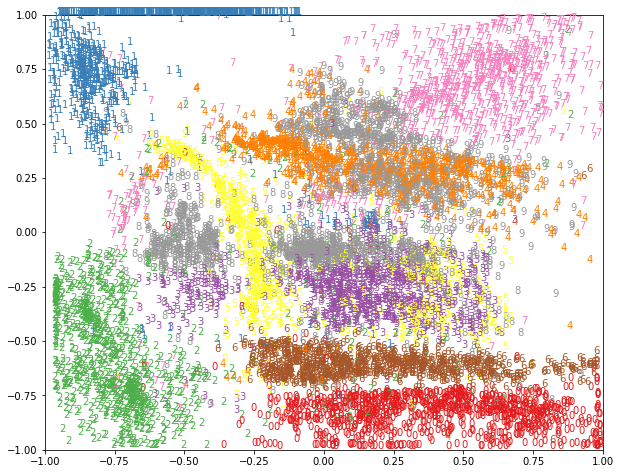

In [24]:
axis_x = []
axis_y = []
answers = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        inputs = data.view(-1, 28*28)
        answers += target.tolist()
        # Forward
        codes, outputs = model_ae(inputs.to(device))
        codes = codes.detach().cpu()
        axis_x += codes[:, 0].tolist()
        axis_y += codes[:, 1].tolist()
answers = np.array(answers)
axis_x = np.array(axis_x)
axis_y = np.array(axis_y)
fig, ax = plt.subplots()
for i in range(len(answers)):
    ax.text(axis_x[i], axis_y[i], str(answers[i]), color=plt.cm.Set1(answers[i]))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()